<a href="https://colab.research.google.com/github/mitsu666/Lecture2021/blob/main/11_recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install surprise

In [4]:
from surprise import SVD
from surprise import NMF
from surprise import Dataset
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
rmse_dic = {}
scored_dic = {}

In [5]:
data = Dataset.load_builtin('ml-100k')
#data.raw_ratings

In [6]:
#訓練、検証データに分割する
trainset, testset = train_test_split(data, test_size=.25,random_state=123)

## KNN

In [7]:
#学習
algo = KNNBasic()
algo.fit(trainset)
#予測
predictions = algo.test(testset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [8]:
temp = pd.DataFrame([pred[0:4] for pred in predictions],columns=['UserID','ItemId','TrueRating','推測値']) 
#例
display(temp)
scored_dic['KNN'] = temp
#平方平均2乗誤差
print (accuracy.rmse(predictions))
rmse_dic['KNN'] = accuracy.rmse(predictions)

,UserID,ItemId,TrueRating,推測値
0,798,480,3.0,4.278078
1,296,462,4.0,3.992136
2,653,258,3.0,4.043072
3,883,239,3.0,3.594985
4,272,187,5.0,4.520559
...,...,...,...,...
24995,717,678,3.0,3.062192
24996,811,258,5.0,3.948962
24997,92,22,3.0,4.300643
24998,389,483,5.0,4.735686


RMSE: 0.9763
0.9762605158799611
RMSE: 0.9763


## SVD法

In [9]:
#学習
algo = SVD()
algo.fit(trainset)
#予測
predictions = algo.test(testset)

In [10]:
temp = pd.DataFrame([pred[0:4] for pred in predictions],columns=['UserID','ItemId','TrueRating','推測値']) 
#例
display(temp)
scored_dic['SVD'] = temp
#平方平均2乗誤差
print (accuracy.rmse(predictions))
rmse_dic['SVD'] = accuracy.rmse(predictions)

,UserID,ItemId,TrueRating,推測値
0,798,480,3.0,4.552166
1,296,462,4.0,4.313098
2,653,258,3.0,3.044688
3,883,239,3.0,3.738817
4,272,187,5.0,4.225985
...,...,...,...,...
24995,717,678,3.0,3.515780
24996,811,258,5.0,4.947735
24997,92,22,3.0,4.050014
24998,389,483,5.0,4.772856


RMSE: 0.9319
0.9319229085953485
RMSE: 0.9319


## 行列分解 NMF

In [11]:
#学習
algo = NMF()
algo.fit(trainset)
#予測
predictions = algo.test(testset)

In [12]:
temp = pd.DataFrame([pred[0:4] for pred in predictions],columns=['UserID','ItemId','TrueRating','推測値']) 
#例
display(temp)
scored_dic['NMF'] = temp
#平方平均2乗誤差
print (accuracy.rmse(predictions))
rmse_dic['NMF'] = accuracy.rmse(predictions)

,UserID,ItemId,TrueRating,推測値
0,798,480,3.0,4.204876
1,296,462,4.0,4.487631
2,653,258,3.0,3.092515
3,883,239,3.0,3.668288
4,272,187,5.0,4.736324
...,...,...,...,...
24995,717,678,3.0,3.473981
24996,811,258,5.0,5.000000
24997,92,22,3.0,4.337511
24998,389,483,5.0,4.392803


RMSE: 0.9598
0.9598472046316071
RMSE: 0.9598


## Surpirse まとめ

In [13]:
for k,v in rmse_dic.items():
  print (k,v)

KNN 0.9762605158799611
SVD 0.9319229085953485
NMF 0.9598472046316071


# fastai


In [14]:
from fastai import *
from fastai.collab import *
from sklearn.model_selection import train_test_split
from surprise import Dataset #dastasetという名前が衝突するため最後にimportする

In [15]:
#Supriseと同じデータを使用する
data = Dataset.load_builtin('ml-100k')
df = pd.DataFrame(data.raw_ratings,columns=['UserID','ItemID','Rating','Timestamp'])
display(df.head())
train ,test = train_test_split(df,test_size=0.25,random_state=12345)

,UserID,ItemID,Rating,Timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


## dotモデル

In [16]:
#データセットをCollabdataBunchで使用できるように変換
data = CollabDataBunch.from_df(train, test = test,  bs=512)
#data.show_batch()
learn = collab_learner(data, n_factors=50, y_range=(1, 5))
print (learn.model)
learn.fit(4)

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1611, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1611, 1)
)


epoch,train_loss,valid_loss,time
0,1.228355,1.044627,00:04
1,0.921161,0.905455,00:04
2,0.778214,0.866483,00:04
3,0.678713,0.852949,00:04


In [17]:
#RMSE計算
tensor = learn.get_preds(ds_type=DatasetType.Test)[0].numpy()
rmse_dic['fastai_dot'] = np.mean((test['Rating']-pd.Series(tensor,index=test.index))**2)**(1/2)
display(pd.concat([test['Rating'],pd.Series(tensor,index=test.index)],axis=1).head())
print (rmse_dic['fastai_dot'])

,Rating,0
71751,4.0,2.557032
80493,3.0,3.297518
2655,4.0,3.251974
53233,4.0,4.080614
91141,5.0,4.174539


0.9289167832638742


## NNモデル

In [31]:
#データセットをCollabdataBunchで使用できるように変換
data = CollabDataBunch.from_df(train, test = test,  bs=512)
#data.show_batch()
learn = collab_learner(data, use_nn=True, y_range=(1, 5),layers=[300,50])
print (learn.model)
learn.fit(4)

EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(944, 74)
    (1): Embedding(1619, 100)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=174, out_features=300, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=300, out_features=50, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)


epoch,train_loss,valid_loss,time
0,0.966473,0.907274,00:05
1,0.876695,0.891928,00:06
2,0.822084,0.884592,00:05
3,0.778525,0.886878,00:06


In [32]:
#RMSE計算
tensor = learn.get_preds(ds_type=DatasetType.Test)[0].numpy().squeeze()
rmse_dic['fastai_nn'] = np.mean((test['Rating']-pd.Series(tensor,index=test.index))**2)**(1/2)
display(pd.concat([test['Rating'],pd.Series(tensor,index=test.index)],axis=1).head())
print (rmse_dic['fastai_nn'])

,Rating,0
71751,4.0,3.054919
80493,3.0,2.954419
2655,4.0,3.030532
53233,4.0,4.094001
91141,5.0,4.191477


0.9524309575879604


{'KNN': 0.9762605158799611, 'SVD': 0.9319229085953485, 'NMF': 0.9598472046316071, 'fastai_dot': 0.9289167832638742, 'fastai_nn': 0.9524309575879604}


Text(0.5, 1.0, 'RMSE')

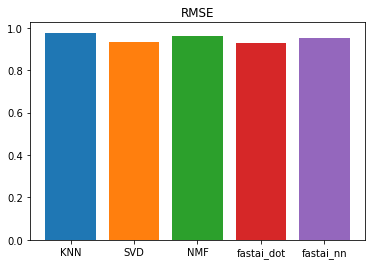

In [35]:
import matplotlib.pyplot as plt
#全体の精度比較
print (rmse_dic)
for k,v in rmse_dic.items():
  plt.bar(k,v)
plt.title("RMSE")

## (参考) 完全データを使用した場合

In [223]:
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import NormalPredictor


# Creation of the dataframe. Column names are irrelevant.
ratings_dict = {'itemID': [1, 1, 1, 2, 2, 2, 3, 3,3],
                'userID': [7, 8, 9, 7, 8,9,7,8,9],
                'rating': [3, 2, 4, 3, 5,2,3,5,3]}
df = pd.DataFrame(ratings_dict)

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

In [224]:
data.raw_ratings

[(7, 1, 3.0, None),
 (8, 1, 2.0, None),
 (9, 1, 4.0, None),
 (7, 2, 3.0, None),
 (8, 2, 5.0, None),
 (9, 2, 2.0, None),
 (7, 3, 3.0, None),
 (8, 3, 5.0, None),
 (9, 3, 3.0, None)]

In [246]:
algo = SVD(n_epochs=1000,biased=False,n_factors=3)
trainset = data.build_full_trainset()
algo.fit(trainset)

In [247]:
for _, row in df.iterrows():
    print (algo.predict(row.userID, row.itemID,r_ui=row.rating))

user: 7          item: 1          r_ui = 3.00   est = 2.93   {'was_impossible': False}
user: 8          item: 1          r_ui = 2.00   est = 2.03   {'was_impossible': False}
user: 9          item: 1          r_ui = 4.00   est = 3.97   {'was_impossible': False}
user: 7          item: 2          r_ui = 3.00   est = 2.85   {'was_impossible': False}
user: 8          item: 2          r_ui = 5.00   est = 5.00   {'was_impossible': False}
user: 9          item: 2          r_ui = 2.00   est = 2.08   {'was_impossible': False}
user: 7          item: 3          r_ui = 3.00   est = 3.14   {'was_impossible': False}
user: 8          item: 3          r_ui = 5.00   est = 4.92   {'was_impossible': False}
user: 9          item: 3          r_ui = 3.00   est = 2.90   {'was_impossible': False}


In [248]:
np.dot((algo.qi.transpose()),algo.pu) 

array([[ 1.4801071 , -2.53222416,  2.46010709],
       [-2.30188848,  6.5533639 , -3.26901764],
       [ 1.50262283, -4.11401783,  2.80251132]])

In [243]:
algo.

array([-0.30924262,  0.56238382, -0.25432872])

In [229]:
from numpy.linalg import svd, matrix_rank
A = np.array(df.groupby(['userID','itemID'])['rating'].max().unstack())

In [230]:
u, s, vh = svd(A)

In [231]:
u.shape

(3, 3)

In [232]:
np.dot(u,np.dot(np.diag(s),vh))

array([[3., 3., 3.],
       [2., 5., 5.],
       [4., 2., 3.]])

In [233]:
u

array([[-0.50785934,  0.20387427, -0.83696725],
       [-0.70357698, -0.65877394,  0.26645138],
       [-0.49704962,  0.72419071,  0.47800574]])

In [234]:
A

array([[3, 3, 3],
       [2, 5, 5],
       [4, 2, 3]])